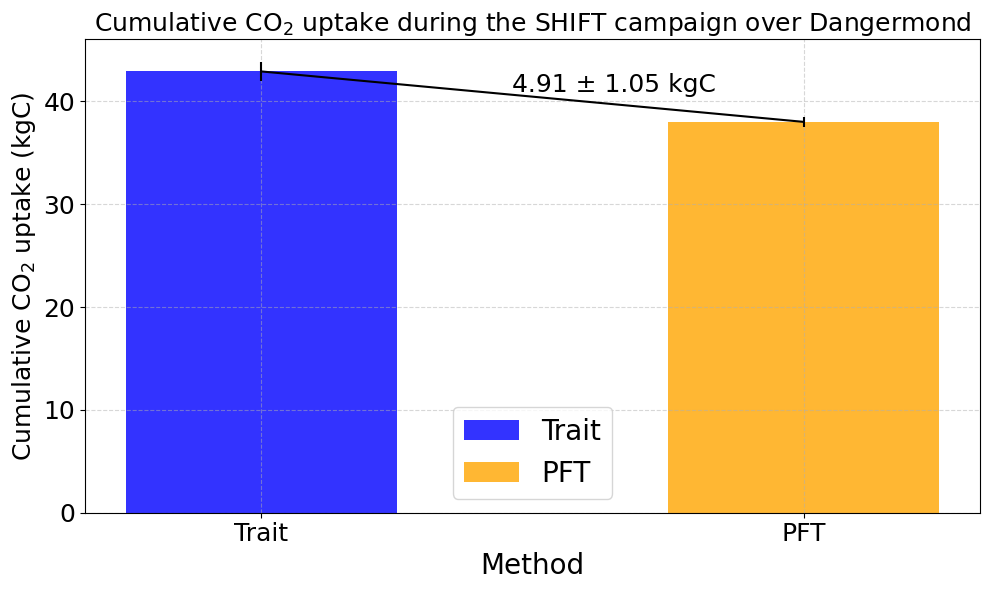

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Constants
AREA_HA = 9903  # Area of Dangermond Preserve in hectares
AREA_M2 = AREA_HA * 1e4  # Convert hectares to square meters
MOL_CO2_TO_KGC = 12.01 / 1e3 / 6.022e23 * 1e12  # Convert micromoles of CO2 to kilograms of C
seconds_per_day = 24 * 3600

# Given dates
dates = [
    "2022-02-24", "2022-02-28", "2022-03-08",
    "2022-03-16", "2022-03-22", "2022-04-05",
    "2022-04-12", "2022-04-20", "2022-04-29",
    "2022-05-03", "2022-05-11", "2022-05-17",
    "2022-05-29"
]

# Base file paths
base_file_path_trait = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/shift_fluxes_day_{:02d}_reg_jmax.nc"
base_file_path_pft = "/net/fluo/data3/data/FluoData1/students/renato/aviris_dangermond/fitting/pft_shift_fluxes_day_{:02d}_jmax.nc"

# Initialize lists to store GPP values for each dataset
gpp_values_trait = []
gpp_values_pft = []

# Convert string dates to pandas datetime objects
date_objects = pd.to_datetime(dates)

for i, date in enumerate(date_objects[:-1]):  # Exclude the last date since there's no next date to average with
    file_trait = base_file_path_trait.format(i + 1)
    file_pft = base_file_path_pft.format(i + 1)
    
    # Ensure that the next files exist
    next_file_trait = base_file_path_trait.format(i + 2 if i + 1 < len(date_objects) else i + 1)
    next_file_pft = base_file_path_pft.format(i + 2 if i + 1 < len(date_objects) else i + 1)

    if not os.path.exists(file_trait) or not os.path.exists(file_pft):
        print(f"File for date {date.strftime('%Y-%m-%d')} not found. Skipping to next date.")
        continue

    ds_trait = xr.open_dataset(file_trait, decode_times=False)
    ds_pft = xr.open_dataset(file_pft, decode_times=False)
    
    if os.path.exists(next_file_trait) and os.path.exists(next_file_pft):
        ds_next_trait = xr.open_dataset(next_file_trait, decode_times=False)
        ds_next_pft = xr.open_dataset(next_file_pft, decode_times=False)
    else:
        ds_next_trait = ds_trait  # Fallback to current file data
        ds_next_pft = ds_pft

    
    avg_gpp_trait = (ds_trait['gpp'].mean(dim=['lat', 'lon']).values + ds_next_trait['gpp'].mean(dim=['lat', 'lon']).values) / 2
    avg_gpp_pft = (ds_pft['gpp'].mean(dim=['lat', 'lon']).values + ds_next_pft['gpp'].mean(dim=['lat', 'lon']).values) / 2
    
    gpp_values_trait.append(avg_gpp_trait * seconds_per_day * AREA_M2 * MOL_CO2_TO_KGC)
    gpp_values_pft.append(avg_gpp_pft * seconds_per_day * AREA_M2 * MOL_CO2_TO_KGC)

#In 13 days (only with measurements)
cumulative_gpp_trait = np.sum(gpp_values_trait)
cumulative_gpp_pft = np.sum(gpp_values_pft)
std_uncertainty_trait = np.std(gpp_values_trait)
std_uncertainty_pft = np.std(gpp_values_pft)

#In (94 - 13) = 81 days (only with measurements)
# 81/13 = 6.23
cumulative_gpp_trait = np.sum(gpp_values_trait)*6.23
cumulative_gpp_pft = np.sum(gpp_values_pft)*6.23
std_uncertainty_trait = np.std(gpp_values_trait)*6.23
std_uncertainty_pft = np.std(gpp_values_pft)*6.23

difference = cumulative_gpp_trait - cumulative_gpp_pft
diff_uncertainty = np.sqrt(std_uncertainty_trait**2 + std_uncertainty_pft**2)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5
index = np.arange(2)
opacity = 0.8

ax.bar(index[0], cumulative_gpp_trait, bar_width, alpha=opacity, color='blue', yerr=std_uncertainty_trait, label='Trait')
ax.bar(index[1], cumulative_gpp_pft, bar_width, alpha=opacity, color='orange', yerr=std_uncertainty_pft, label='PFT')

# Formatting the plot
ax.set_xlabel('Method', fontsize=20)
ax.set_ylabel('Cumulative CO$_2$ uptake (kgC)', fontsize=18)
ax.set_title('Cumulative CO$_2$ uptake during the SHIFT campaign over Dangermond', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(['Trait', 'PFT'], fontsize=18)
ax.legend(fontsize=20)

# Customize grid lines
ax.grid(True, which='major', linestyle='--', alpha=0.5)

# Display the difference
ax.plot([index[0], index[1]], [cumulative_gpp_trait, cumulative_gpp_pft], 'k-')
ax.text(index.mean() + .15, (cumulative_gpp_trait + cumulative_gpp_pft) / 2, f'{difference:.2f} ± {diff_uncertainty:.2f} kgC', rotation=0, ha='center', va='bottom', fontsize=18)

# Increase y-axis tick font size
ax.tick_params(axis='y', labelsize=18)

# Save and show the plot
plt.tight_layout()
plt.savefig('cumulative_gpp_comparison.png', dpi=300)
plt.show()

